In [1]:
from pathlib import Path
from LHC_FillingPattern import LHCFillingPattern 
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import pandas as pd
from matplotlib.lines import Line2D
from scipy.integrate import cumtrapz 

In [2]:
DATADIR = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/md_data/MD15363""/HX:FILLN=10739/")
df = pd.read_parquet(DATADIR)   
#print(df.columns.tolist())
#fbmodes = pd.read_parquet(DATADIR)

In [3]:
ATLAS_PV = "ATLAS:BUNCH_LUMI_INST" 
CMS_PV = 'CMS:BUNCH_LUMI_INST'
BETASTAR_PV    = "HX:BETASTAR_IP1" #'HX:BETASTAR_IP1', HX:BETASTAR_IP2', 'HX:BETASTAR_IP5', 'HX:BETASTAR_IP8'
XING_PV = 'LhcStateTracker:LHCBEAM:IP1-XING-H-MURAD:value'

bids = [20, 500, 1250, 1800,2874]  

## ATLAs

### First Window

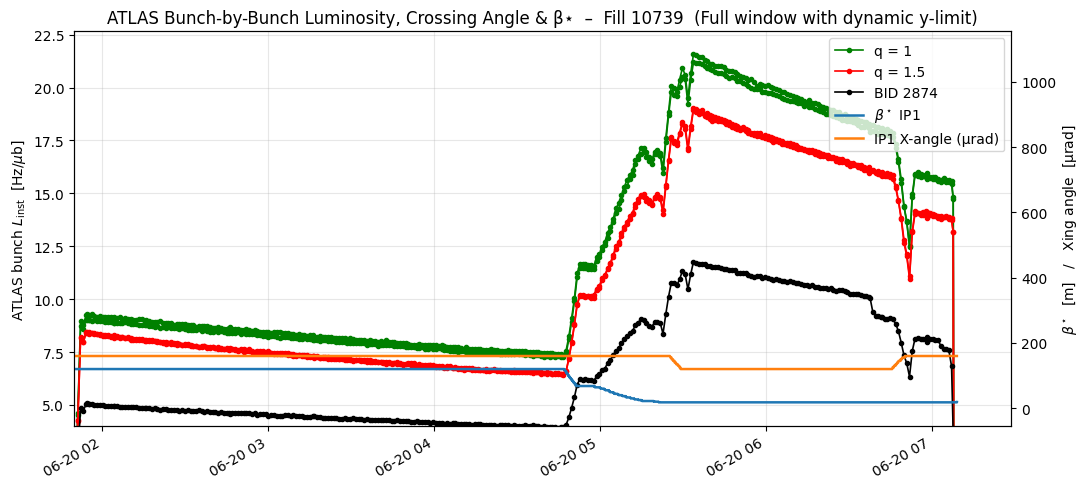

In [4]:
BUNCH_GROUPS_ATLAS = {
    "q = 1"  : ([20, 500],    "green"),
    "q = 1.5": ([1250, 1800], "red"),
}
SOLO_BID_ATLAS     = 2874  # plotted in black
DYNAMIC_YLIM_ATLAS = True  # Enable dynamic y-axis scaling
TITLE_SUFFIX_ATLAS = "Full window with dynamic y-limit"

# --- Load data ---
def load_bunch_array_atlas(pv_name: str, bid_list):
    raw_atlas = (
        dd.read_parquet(DATADIR, columns=[pv_name])
          .dropna()
          .compute()
    )
    raw_atlas.index = pd.to_datetime(raw_atlas.index, unit="ns")
    raw_atlas.sort_index(inplace=True)
    mat_atlas    = np.stack(raw_atlas[pv_name].values)  # nTimes × 3564
    sliced_atlas = mat_atlas[:, bid_list]
    return pd.DataFrame(
        sliced_atlas,
        index   = raw_atlas.index,
        columns = [f"B{bid}" for bid in bid_list]
    )

all_bids_atlas = [*BUNCH_GROUPS_ATLAS["q = 1"][0], *BUNCH_GROUPS_ATLAS["q = 1.5"][0], SOLO_BID_ATLAS]
df_atlas       = load_bunch_array_atlas(ATLAS_PV, all_bids_atlas)

df_beta_atlas = (
    dd.read_parquet(DATADIR, columns=[BETASTAR_PV])
      .dropna()
      .compute()
)
df_beta_atlas.index = pd.to_datetime(df_beta_atlas.index, unit="ns")
df_beta_atlas.sort_index(inplace=True)

df_xing_atlas = (
    dd.read_parquet(DATADIR, columns=[XING_PV])
      .dropna()
      .compute()
)
df_xing_atlas.index = pd.to_datetime(df_xing_atlas.index, unit="ns")
df_xing_atlas.sort_index(inplace=True)

# --- Synchronize time range across datasets ---
t0_atlas = max(df_atlas.index.min(), df_beta_atlas.index.min(), df_xing_atlas.index.min())
t1_atlas = min(df_atlas.index.max(), df_beta_atlas.index.max(), df_xing_atlas.index.max())
df_atlas      = df_atlas.loc[t0_atlas:t1_atlas]
df_beta_atlas = df_beta_atlas.loc[t0_atlas:t1_atlas]
df_xing_atlas = df_xing_atlas.loc[t0_atlas:t1_atlas]

# --- Plotting ---
fig_atlas, ax_lumi_atlas = plt.subplots(figsize=(11, 5))

# Bunch-by-bunch luminosity
for lbl_atlas, (bids_atlas, colour_atlas) in BUNCH_GROUPS_ATLAS.items():
    df_atlas[[f"B{b}" for b in bids_atlas]].plot(
        ax         = ax_lumi_atlas,
        color      = colour_atlas,
        linewidth  = 1.2,
        marker     = ".",
        legend     = False
    )
ax_lumi_atlas.plot(
    df_atlas.index,
    df_atlas[f"B{SOLO_BID_ATLAS}"],
    color     = "black",
    linewidth = 1.2,
    marker    = ".",
    label     = "_nolegend_"
)
ax_lumi_atlas.set_ylabel(r"ATLAS bunch $L_{\rm inst}$  [Hz/$\mu$b]")

# --- Dynamic y-limit ---
if DYNAMIC_YLIM_ATLAS:
    y_max_atlas = df_atlas.max().max()
    ax_lumi_atlas.set_ylim(4, y_max_atlas * 1.05)  # 5% headroom
else:
    ax_lumi_atlas.set_ylim(4, 9.5)

# Title
ax_lumi_atlas.set_title(
    f"ATLAS Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  ({TITLE_SUFFIX_ATLAS})"
)
ax_lumi_atlas.grid(alpha=0.3)

# Right axis: β⋆ and crossing angle
ax_r_atlas = ax_lumi_atlas.twinx()
df_beta_atlas[BETASTAR_PV].plot(
    ax         = ax_r_atlas,
    color      = "tab:blue",
    linewidth  = 1.8,
    label      = r"$\beta^\star$ IP1"
)
df_xing_atlas[XING_PV].plot(
    ax         = ax_r_atlas,
    color      = "tab:orange",
    linewidth  = 1.8,
    label      = r"IP1 X-angle (µrad)"
)
ax_r_atlas.set_ylabel(r"$\beta^\star$  [m]   /   Xing angle  [µrad]")

# Legend
custom_handles_atlas = [
    Line2D([0], [0], color="green",  marker=".", linestyle="-", linewidth=1.2, label="q = 1"),
    Line2D([0], [0], color="red",    marker=".", linestyle="-", linewidth=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black",  marker=".", linestyle="-", linewidth=1.2, label=f"BID {SOLO_BID_ATLAS}"),
    ax_r_atlas.lines[0],
    ax_r_atlas.lines[1],
]
ax_lumi_atlas.legend(handles=custom_handles_atlas, loc="upper right")

# Optional x-range zoom
ax_lumi_atlas.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

plt.tight_layout()
plt.show()


ATLAS: β⋆ starts changing (after 04:00) at: 2025-06-20 04:47:13.295738525


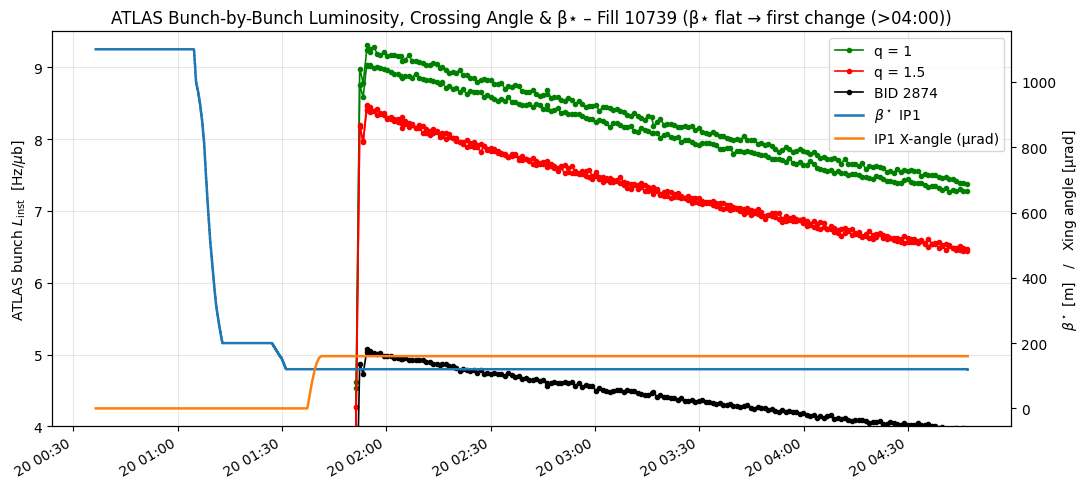

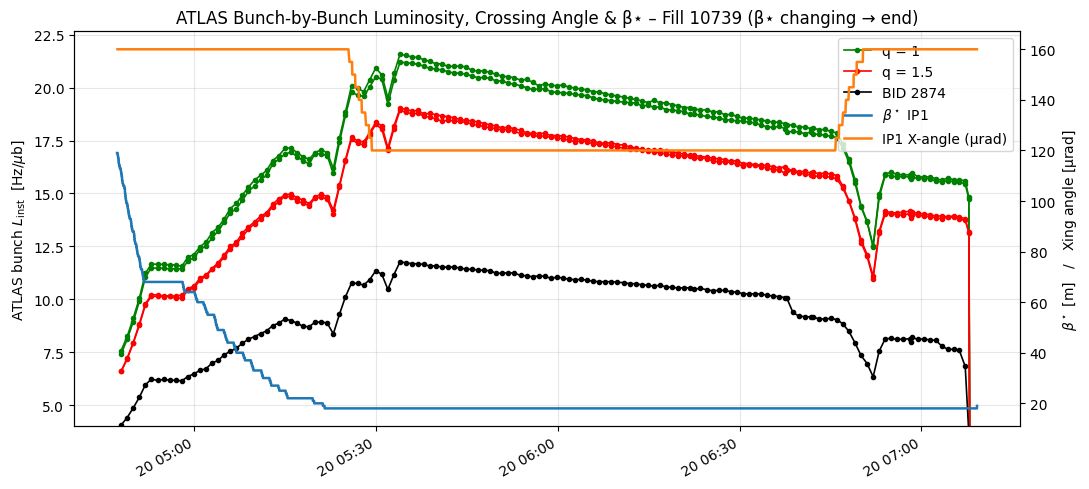

In [5]:
# Find when β⋆ first changes for ATLAS *after 04:00* on that day
tol_atlas       = 1e-4
day0_atlas      = df_beta_atlas.index[0].floor("D")
t_threshold_atlas = day0_atlas + pd.Timedelta(hours=4)
beta_series_atlas = df_beta_atlas[BETASTAR_PV]

# value that β⋆ still had *at* 04:00 (or last tick before it)
baseline_atlas = beta_series_atlas.loc[:t_threshold_atlas].iloc[-1]

# first time *after* 04:00 that |β⋆−baseline| > tol
after_4h_atlas = beta_series_atlas.loc[t_threshold_atlas:]
t_change_atlas = after_4h_atlas[(after_4h_atlas - baseline_atlas).abs() > tol_atlas].index[0]
print("ATLAS: β⋆ starts changing (after 04:00) at:", t_change_atlas)


def plot_window_atlas(t_start_atlas, t_stop_atlas, title_suffix_atlas, dynamic_ylim_atlas=False):
    sl_atlas     = df_atlas.loc[t_start_atlas:t_stop_atlas]
    sl_beta_atlas = df_beta_atlas.loc[t_start_atlas:t_stop_atlas]
    sl_xing_atlas = df_xing_atlas.loc[t_start_atlas:t_stop_atlas]

    fig_atlas, ax_lumi_atlas = plt.subplots(figsize=(11, 5))

    # left axis – all ATLAS bunch curves
    for lbl_atlas, (bids_atlas, colour_atlas) in BUNCH_GROUPS_ATLAS.items():
        sl_atlas[[f"B{b}" for b in bids_atlas]].plot(
            ax      = ax_lumi_atlas,
            color   = colour_atlas,
            lw      = 1.2,
            marker  = ".",
            legend  = False
        )
    ax_lumi_atlas.plot(
        sl_atlas.index,
        sl_atlas[f"B{SOLO_BID_ATLAS}"],
        color   = "black",
        lw      = 1.2,
        marker  = ".",
        label   = "_nolegend_"
    )
    ax_lumi_atlas.set_ylabel(r"ATLAS bunch $L_{\rm inst}$  [Hz/$\mu$b]")
    if dynamic_ylim_atlas:
        y_max_atlas = sl_atlas.max().max()
        ax_lumi_atlas.set_ylim(4, y_max_atlas * 1.05)  # 5% headroom above max
    else:
        ax_lumi_atlas.set_ylim(4, 9.5)

    ax_lumi_atlas.set_title(
        f"ATLAS Bunch-by-Bunch Luminosity, Crossing Angle & β⋆ – Fill 10739 ({title_suffix_atlas})"
    )
    ax_lumi_atlas.grid(alpha=0.3)

    # right axis – β⋆ and crossing angle
    ax_r_atlas = ax_lumi_atlas.twinx()
    sl_beta_atlas[BETASTAR_PV].plot(
        ax      = ax_r_atlas,
        color   = "tab:blue",
        lw      = 1.8,
        label   = r"$\beta^\star$ IP1"
    )
    sl_xing_atlas[XING_PV].plot(
        ax      = ax_r_atlas,
        color   = "tab:orange",
        lw      = 1.8,
        label   = r"IP1 X-angle (µrad)"
    )
    ax_r_atlas.set_ylabel(r"$\beta^\star$ [m]   /   Xing angle [µrad]")

    # combined legend
    handles_atlas = [
        Line2D([0], [0], color="green",  marker=".", lw=1.2, label="q = 1"),
        Line2D([0], [0], color="red",    marker=".", lw=1.2, label="q = 1.5"),
        Line2D([0], [0], color="black",  marker=".", lw=1.2, label=f"BID {SOLO_BID_ATLAS}"),
        ax_r_atlas.lines[0],  # β⋆
        ax_r_atlas.lines[1],  # Xing angle
    ]
    ax_lumi_atlas.legend(handles=handles_atlas, loc="upper right")
    plt.tight_layout()
    return fig_atlas

# Draw the two panels: before and after β⋆ begins to change
fig_before_atlas = plot_window_atlas(
    df_atlas.index.min(), 
    t_change_atlas,
    "β⋆ flat → first change (>04:00)"
)
fig_after_atlas  = plot_window_atlas(
    t_change_atlas, 
    df_atlas.index.max(),
    "β⋆ changing → end",
    dynamic_ylim_atlas=True
)

plt.show()


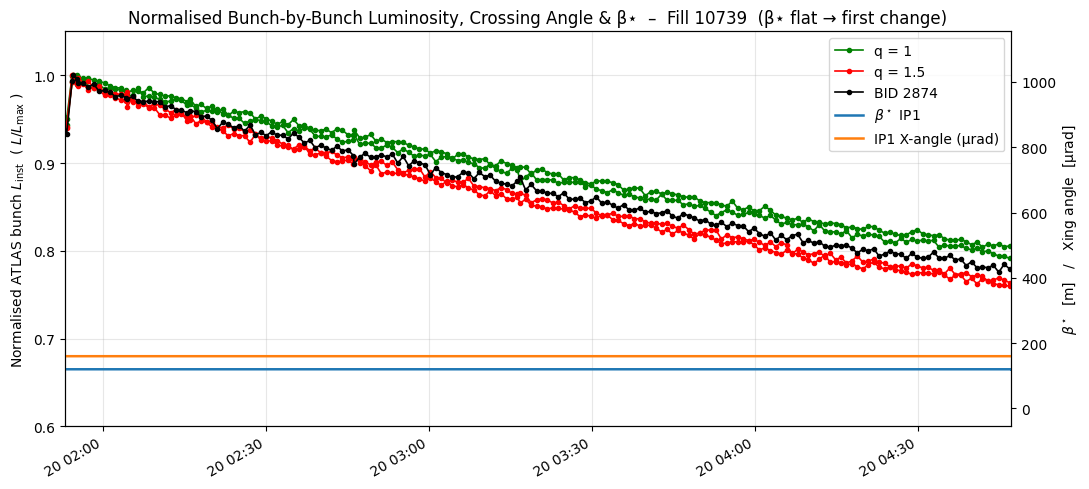

In [6]:
# ────────────────────────────────────────────────────────────────────
# Normalised bunch-by-bunch luminosity during the *first* split (ATLAS)
# ────────────────────────────────────────────────────────────────────

# 1) slice the data to the “before β⋆-change” period
df_first_atlas     = df_atlas.loc[df_atlas.index.min() : t_change_atlas]
beta_first_atlas   = df_beta_atlas.loc[df_beta_atlas.index.min() : t_change_atlas]
xing_first_atlas   = df_xing_atlas.loc[df_xing_atlas.index.min() : t_change_atlas]

# 2) per-bunch maxima in that window
max_vals_atlas     = df_first_atlas.max()

# 3) normalise every bunch curve by its own maximum
df_norm_first_atlas = df_first_atlas.div(max_vals_atlas)

# 4) plot – same style as the original panel
fig_norm_atlas, ax_lum_atlas = plt.subplots(figsize=(11, 5))

for lbl_atlas, (bids_atlas, colour_atlas) in BUNCH_GROUPS_ATLAS.items():
    df_norm_first_atlas[[f"B{b}" for b in bids_atlas]].plot(
        ax     = ax_lum_atlas,
        color  = colour_atlas,
        lw     = 1.2,
        marker = ".",
        legend = False
    )

# solo bunch
ax_lum_atlas.plot(
    df_norm_first_atlas.index,
    df_norm_first_atlas[f"B{SOLO_BID_ATLAS}"],
    color  = "black",
    lw     = 1.2,
    marker = ".",
    label  = "_nolegend_"
)

ax_lum_atlas.set_ylabel(
    r"Normalised ATLAS bunch $L_{\rm inst}$  ( $L/L_{\max}$ )"
)
ax_lum_atlas.set_ylim(0.6, 1.05)
ax_lum_atlas.set_title(
    "Normalised Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  "
    "(β⋆ flat → first change)"
)
ax_lum_atlas.grid(alpha=0.3)

# right axis – β⋆ and crossing angle (absolute units)
ax_r_atlas = ax_lum_atlas.twinx()
beta_first_atlas[BETASTAR_PV].plot(
    ax    = ax_r_atlas,
    color = "tab:blue",
    lw    = 1.8,
    label = r"$\beta^\star$ IP1"
)
xing_first_atlas[XING_PV].plot(
    ax    = ax_r_atlas,
    color = "tab:orange",
    lw    = 1.8,
    label = r"IP1 X-angle (µrad)"
)
ax_r_atlas.set_ylabel(r"$\beta^\star$  [m]   /   Xing angle  [µrad]")

# combined legend
handles_atlas = [
    Line2D([0], [0], color="green",  marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",    marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black",  marker=".", lw=1.2, label=f"BID {SOLO_BID_ATLAS}"),
    ax_r_atlas.lines[0],  # β⋆
    ax_r_atlas.lines[1],  # crossing angle
]
# set x-axis limits
start_time_atlas = df_first_atlas.index[0].replace(hour=1, minute=53, second=0)
ax_lum_atlas.set_xlim([start_time_atlas, t_change_atlas])
ax_lum_atlas.legend(handles=handles_atlas, loc="upper right")

plt.tight_layout()
plt.show()


/tmp/ipykernel_3507598/2717993296.py:17: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  {col: cumtrapz(df_norm_first_atlas[col].values, t_sec_atlas, initial=0.0)


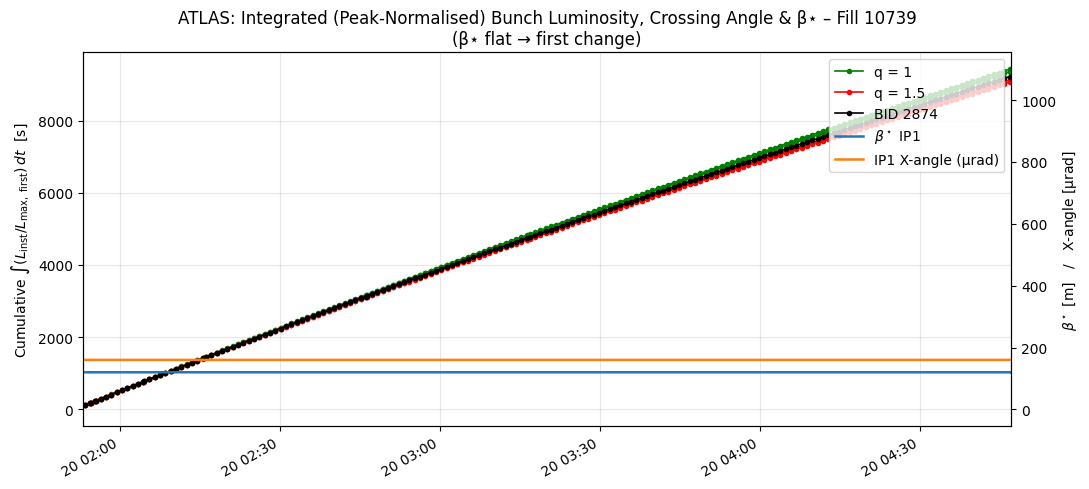

In [7]:
# ─────────────────────────────────────────────────────────────────────
# ATLAS: Integrated (Peak-Normalised) Bunch Luminosity – β⋆ flat → first change
# ─────────────────────────────────────────────────────────────────────

# A) prepare the first-window data (β⋆ still flat)
df_first_atlas     = df_atlas.loc[df_atlas.index.min() : t_change_atlas]
beta_first_atlas   = df_beta_atlas.loc[df_beta_atlas.index.min() : t_change_atlas]
xing_first_atlas   = df_xing_atlas.loc[df_xing_atlas.index.min() : t_change_atlas]

# B) normalise every ATLAS bunch by its own maximum in that window
max_vals_first_atlas = df_first_atlas.max()           # Series: one max per column
df_norm_first_atlas  = df_first_atlas.div(max_vals_first_atlas)

# C) cumulative integral of the normalised curves (units → seconds)
t_sec_atlas = (df_norm_first_atlas.index - df_norm_first_atlas.index[0]).total_seconds()
df_cum_norm_atlas = pd.DataFrame(
    {col: cumtrapz(df_norm_first_atlas[col].values, t_sec_atlas, initial=0.0)
     for col in df_norm_first_atlas.columns},
    index=df_norm_first_atlas.index
)

# D) plot
fig_atlas, ax_l_atlas = plt.subplots(figsize=(11, 5))

# left axis – cumulative ∫(L / L_peak) dt for each group
for lbl_atlas, (bids_atlas, colour_atlas) in BUNCH_GROUPS_ATLAS.items():
    df_cum_norm_atlas[[f"B{b}" for b in bids_atlas]].plot(
        ax      = ax_l_atlas,
        color   = colour_atlas,
        lw      = 1.2,
        marker  = ".",
        legend  = False
    )

# solo ATLAS bunch
ax_l_atlas.plot(
    df_cum_norm_atlas.index,
    df_cum_norm_atlas[f"B{SOLO_BID_ATLAS}"],
    color   = "black",
    lw      = 1.2,
    marker  = ".",
    label   = "_nolegend_"
)

ax_l_atlas.set_ylabel(
    r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm first}})\,dt$  [s]"
)
ax_l_atlas.set_title(
    "ATLAS: Integrated (Peak-Normalised) Bunch Luminosity, Crossing Angle & β⋆ – Fill 10739\n"
    "(β⋆ flat → first change)"
)
ax_l_atlas.grid(alpha=0.3)

# right axis – β⋆ and crossing angle
ax_r_atlas = ax_l_atlas.twinx()
beta_first_atlas[BETASTAR_PV].plot(
    ax    = ax_r_atlas,
    color = "tab:blue",
    lw    = 1.8,
    label = r"$\beta^\star$ IP1"
)
xing_first_atlas[XING_PV].plot(
    ax    = ax_r_atlas,
    color = "tab:orange",
    lw    = 1.8,
    label = r"IP1 X-angle (µrad)"
)
ax_r_atlas.set_ylabel(r"$\beta^\star$ [m]   /   X-angle [µrad]")

# combined legend
handles_atlas = [
    Line2D([0], [0], color="green",  marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",    marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black",  marker=".", lw=1.2, label=f"BID {SOLO_BID_ATLAS}"),
    ax_r_atlas.lines[0],  # β⋆
    ax_r_atlas.lines[1],  # crossing angle
]
ax_l_atlas.legend(handles=handles_atlas, loc="upper right")

# optional: same x-range as before
start_time_atlas = df_norm_first_atlas.index[0].replace(hour=1, minute=53, second=0)
ax_l_atlas.set_xlim([start_time_atlas, t_change_atlas])

plt.tight_layout()
plt.show()


In [8]:
# Grab the last row of the ATLAS peak‐normalised cumulative‐luminosity DataFrame
final_values_norm_atlas = df_cum_norm_atlas.iloc[-1]

print("ATLAS: Peak-normalised cumulative luminosity delivered up to β⋆ change:")
print(final_values_norm_atlas.to_string(float_format="%.3e"))

# %-difference functions (reuse or redefine as needed)
def sym_pct_diff(a, b):
    """Symmetric % difference between a and b."""
    return 100 * (b - a) / ((a + b) / 2)

def rel_pct_diff(ref, comp):
    """Relative % difference of comp vs. ref."""
    return 100 * (comp - ref) / ref

# Define the two ATLAS groups
group_q1_atlas  = ["B20", "B500"]
group_q15_atlas = ["B1250", "B1800"]

# Compute the group means at the moment of β⋆ change
tot_q1_atlas  = final_values_norm_atlas[group_q1_atlas].mean()
tot_q15_atlas = final_values_norm_atlas[group_q15_atlas].mean()

# Compute % differences
sym_pct_atlas = sym_pct_diff(tot_q1_atlas, tot_q15_atlas)
rel_pct_atlas = rel_pct_diff(tot_q1_atlas, tot_q15_atlas)

# Print out the ATLAS‐specific results
print("\nATLAS: Peak-normalised cumulative luminosity at β⋆ change:")
print(f"  q = 1 total (B20 + B500):     {tot_q1_atlas : .3e} s")
print(f"  q = 1.5 total (B1250 + B1800): {tot_q15_atlas: .3e} s")
print(f"  Symmetric % difference:        {sym_pct_atlas:.3f} %")
print(f"  Relative % difference (ref q=1): {rel_pct_atlas:.3f} %")


ATLAS: Peak-normalised cumulative luminosity delivered up to β⋆ change:
B20     9.425e+03
B500    9.354e+03
B1250   9.126e+03
B1800   9.070e+03
B2874   9.219e+03

ATLAS: Peak-normalised cumulative luminosity at β⋆ change:
  q = 1 total (B20 + B500):      9.389e+03 s
  q = 1.5 total (B1250 + B1800):  9.098e+03 s
  Symmetric % difference:        -3.153 %
  Relative % difference (ref q=1): -3.104 %


### Second window

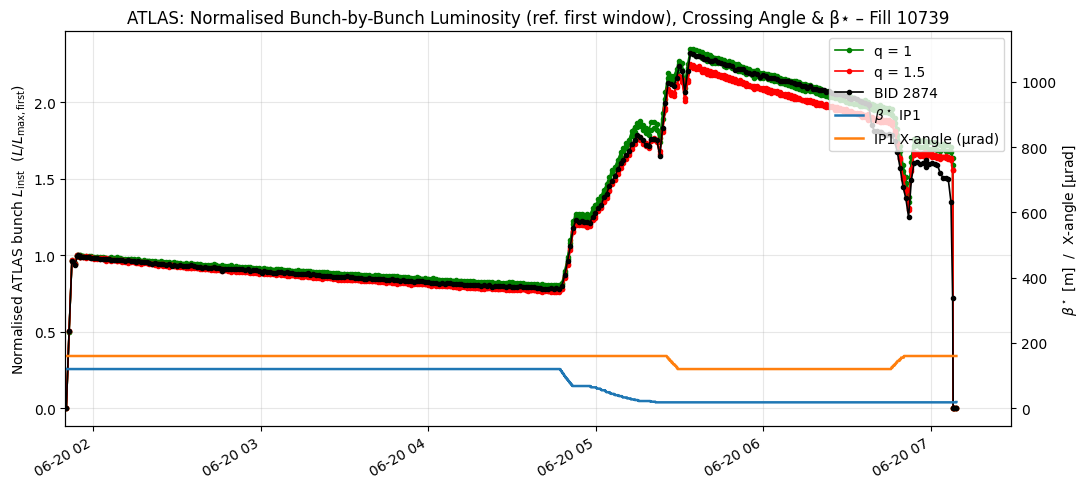

In [9]:
# ─────────────────────────────────────────────────────────────────────
# ATLAS: Normalise the whole fill to the first-window peak of each bunch
# ─────────────────────────────────────────────────────────────────────

# 1) reference maxima from the first split (β⋆ flat → t_change_atlas)
max_first_atlas = df_atlas.loc[t0_atlas:t_change_atlas].max()

# 2) normalise the entire df_atlas by those maxima
df_norm_all_atlas = df_atlas.div(max_first_atlas)

# 3) plot – same layout as your original figure, but ATLAS-specific
pad_atlas   = 0.05  # 5% head- & foot-room
ymin_atlas  = df_norm_all_atlas.min().min()
ymax_atlas  = df_norm_all_atlas.max().max()
yrange_atlas = ymax_atlas - ymin_atlas
ylow_atlas  = ymin_atlas - pad_atlas * yrange_atlas
yhigh_atlas = ymax_atlas + pad_atlas * yrange_atlas

fig_atlas, ax_l_atlas = plt.subplots(figsize=(11, 5))

for lbl_atlas, (bids_atlas, colour_atlas) in BUNCH_GROUPS_ATLAS.items():
    df_norm_all_atlas[[f"B{b}" for b in bids_atlas]].plot(
        ax      = ax_l_atlas,
        color   = colour_atlas,
        lw      = 1.2,
        marker  = ".",
        legend  = False
    )

ax_l_atlas.plot(
    df_norm_all_atlas.index,
    df_norm_all_atlas[f"B{SOLO_BID_ATLAS}"],
    color   = "black",
    lw      = 1.2,
    marker  = ".",
    label   = "_nolegend_"
)

ax_l_atlas.set_ylabel(
    r"Normalised ATLAS bunch $L_{\rm inst}$  ($L/L_{\max,\mathrm{first}}$)"
)
ax_l_atlas.set_ylim(ylow_atlas, yhigh_atlas)  # dynamic limits
ax_l_atlas.set_title(
    "ATLAS: Normalised Bunch-by-Bunch Luminosity (ref. first window), "
    "Crossing Angle & β⋆ – Fill 10739"
)
ax_l_atlas.grid(alpha=0.3)

# right-axis traces stay the same but use Atlas β⋆/X data
ax_r_atlas = ax_l_atlas.twinx()
df_beta_atlas[BETASTAR_PV].plot(
    ax    = ax_r_atlas,
    color = "tab:blue",
    lw    = 1.8,
    label = r"$\beta^\star$ IP1"
)
df_xing_atlas[XING_PV].plot(
    ax    = ax_r_atlas,
    color = "tab:orange",
    lw    = 1.8,
    label = r"IP1 X-angle (µrad)"
)
ax_r_atlas.set_ylabel(r"$\beta^\star$ [m]  /  X-angle [µrad]")

handles_atlas = [
    Line2D([0], [0], color="green",  marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",    marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black",  marker=".", lw=1.2, label=f"BID {SOLO_BID_ATLAS}"),
    ax_r_atlas.lines[0],
    ax_r_atlas.lines[1],
]
ax_l_atlas.legend(handles=handles_atlas, loc="upper right")
ax_l_atlas.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

plt.tight_layout()
plt.show()


/tmp/ipykernel_3507598/1064119774.py:4: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  {col: cumtrapz(df_norm_all_atlas[col].values, t_sec_all_atlas, initial=0.0)


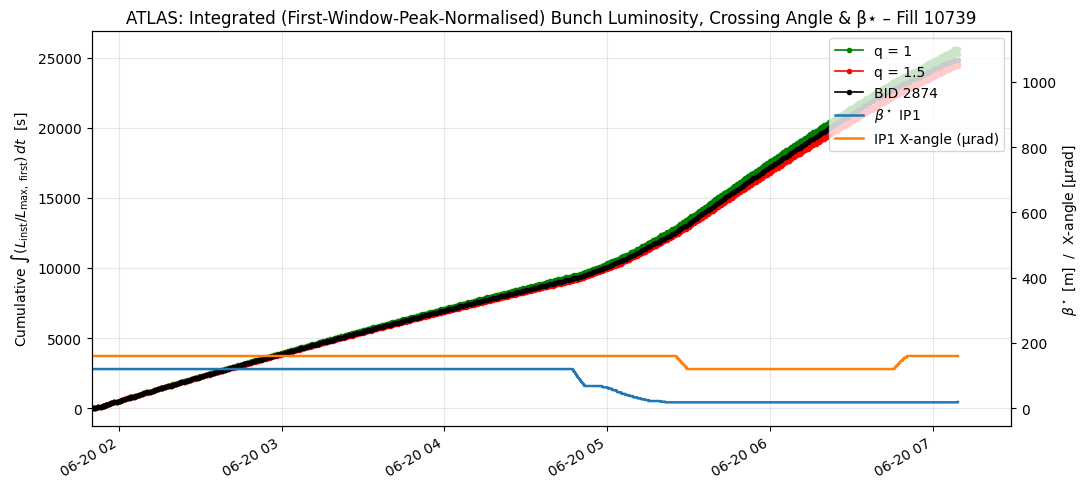

In [10]:
# 1) cumulative integral for each ATLAS bunch
t_sec_all_atlas = (df_norm_all_atlas.index - df_norm_all_atlas.index[0]).total_seconds()
df_cum_all_atlas = pd.DataFrame(
    {col: cumtrapz(df_norm_all_atlas[col].values, t_sec_all_atlas, initial=0.0)
     for col in df_norm_all_atlas.columns},
    index=df_norm_all_atlas.index
)

# 2) dynamic y-range (±5% padding)
pad_atlas       = 0.05
ymin_atlas      = df_cum_all_atlas.min().min()
ymax_atlas      = df_cum_all_atlas.max().max()
yrange_atlas    = ymax_atlas - ymin_atlas
ylow_atlas      = ymin_atlas - pad_atlas * yrange_atlas
yhigh_atlas     = ymax_atlas + pad_atlas * yrange_atlas

# 3) plot
fig_int_atlas, ax_l_atlas = plt.subplots(figsize=(11, 5))

for lbl_atlas, (bids_atlas, colour_atlas) in BUNCH_GROUPS_ATLAS.items():
    df_cum_all_atlas[[f"B{b}" for b in bids_atlas]].plot(
        ax      = ax_l_atlas,
        color   = colour_atlas,
        lw      = 1.2,
        marker  = ".",
        label   = lbl_atlas
    )

# plot the solo ATLAS bunch
ax_l_atlas.plot(
    df_cum_all_atlas.index,
    df_cum_all_atlas[f"B{SOLO_BID_ATLAS}"],
    color   = "black",
    lw      = 1.2,
    marker  = ".",
    label   = f"BID {SOLO_BID_ATLAS}"
)

ax_l_atlas.set_ylabel(
    r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm first}})\,dt$  [s]"
)
ax_l_atlas.set_ylim(ylow_atlas, yhigh_atlas)
ax_l_atlas.set_title(
    "ATLAS: Integrated (First-Window-Peak-Normalised) Bunch Luminosity, "
    "Crossing Angle & β⋆ – Fill 10739"
)
ax_l_atlas.grid(alpha=0.3)

# right axis – β⋆ & crossing angle
ax_r_atlas = ax_l_atlas.twinx()
df_beta_atlas[BETASTAR_PV].plot(
    ax    = ax_r_atlas,
    color = "tab:blue",
    lw    = 1.8,
    label = r"$\beta^\star$ IP1"
)
df_xing_atlas[XING_PV].plot(
    ax    = ax_r_atlas,
    color = "tab:orange",
    lw    = 1.8,
    label = r"IP1 X-angle (µrad)"
)
ax_r_atlas.set_ylabel(r"$\beta^\star$ [m]  /  X-angle [µrad]")

# combined legend
handles_atlas = [
    Line2D([0], [0], color="green",  marker=".", lw=1.2, label="q = 1"),
    Line2D([0], [0], color="red",    marker=".", lw=1.2, label="q = 1.5"),
    Line2D([0], [0], color="black",  marker=".", lw=1.2, label=f"BID {SOLO_BID_ATLAS}"),
    ax_r_atlas.lines[0],  # β⋆
    ax_r_atlas.lines[1],  # X-angle
]
ax_l_atlas.legend(handles=handles_atlas, loc="upper right")

# optional x-range zoom
ax_l_atlas.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))

plt.tight_layout()
plt.show()


In [11]:
# Grab the last row of the ATLAS cumulative‐luminosity DataFrame
final_values_norm_all_atlas = df_cum_all_atlas.iloc[-1]   # units: seconds

print("ATLAS: Peak-normalised cumulative luminosity delivered over the whole fill:")
print(final_values_norm_all_atlas.to_string(float_format="%.3e"))

# Define your ATLAS groups
group_q1_all_atlas   = ["B20", "B500"]        # q = 1
group_q15_all_atlas  = ["B1250", "B1800"]     # q = 1.5

# Compute totals for each group
tot_q1_all_atlas  = final_values_norm_all_atlas[group_q1_all_atlas].sum()
tot_q15_all_atlas = final_values_norm_all_atlas[group_q15_all_atlas].sum()

# Compute % differences (using the functions you defined earlier)
rel_tot_all_atlas = rel_pct_diff(tot_q1_all_atlas,  tot_q15_all_atlas)   # reference = q1 total
sym_tot_all_atlas = sym_pct_diff(tot_q1_all_atlas, tot_q15_all_atlas)    # symmetric

# Print the ATLAS‐specific summary
print("\nATLAS: Peak-normalised cumulative luminosity over the whole fill (seconds):\n")
print(f"  q = 1   total (B20 + B500)   : {tot_q1_all_atlas  : .3e}  s")
print(f"  q = 1.5 total (B1250 + B1800): {tot_q15_all_atlas : .3e}  s")
print(f"\n  Relative  % diff (ref q = 1 total): {rel_tot_all_atlas:8.4f} %")
print(f"  Symmetric % diff:                    {sym_tot_all_atlas:8.4f} %")


ATLAS: Peak-normalised cumulative luminosity delivered over the whole fill:
B20     2.560e+04
B500    2.526e+04
B1250   2.455e+04
B1800   2.437e+04
B2874   2.483e+04

ATLAS: Peak-normalised cumulative luminosity over the whole fill (seconds):

  q = 1   total (B20 + B500)   :  5.085e+04  s
  q = 1.5 total (B1250 + B1800):  4.892e+04  s

  Relative  % diff (ref q = 1 total):  -3.8045 %
  Symmetric % diff:                     -3.8783 %
